In [136]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, LSTM
from keras.optimizers import RMSprop
from keras.layers import SimpleRNN


import math
import pandas as pd

import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt


In [382]:
file_path = "dataA.csv"

In [383]:
# read csv file from data.csv file
nepse_df = pd.read_csv(file_path, header = 0)

In [384]:
# Check the data in the top of the dataframe
nepse_df.head()

,Symbol,Date,Open,High,Low,Close,percent_change,Volume
0,LBBL,7/15/2022,340.1,347.7,337.0,341.0,-0.87,21063
1,LBBL,7/14/2022,344.0,350.0,332.0,344.0,1.78,52442
2,LBBL,7/13/2022,321.0,338.6,316.0,338.0,7.30,51519
3,LBBL,07/12/2022,321.0,329.4,310.0,315.0,0.03,52363
4,LBBL,07/11/2022,324.0,325.1,310.0,314.9,-4.60,71293


In [385]:
# Check of null or missing data
nepse_df.isnull().sum()

Symbol            0
Date              0
Open              0
High              0
Low               0
Close             0
percent_change    0
Volume            0
dtype: int64

In [386]:
# Filter data based on choice
class CustomError(Exception):
  pass

scrip_list = list(nepse_df['Symbol'].unique())
print("Available Scrip are", scrip_list)
SCRIP = input("Enter the Scrip you want to analyze: ")

if SCRIP in scrip_list:
  nepse_df = nepse_df[nepse_df['Symbol'] == SCRIP]
else:
  print("Scrip is not valid")
  raise CustomError("Wrong Input")

Available Scrip are ['LBBL', 'NABIL', 'NBL', 'NHPC', 'SICL']


In [387]:
# Perform 80 - 20 split for training and test data
values = nepse_df['Close'].values
training_data_len = math.ceil(len(values)* 0.8)

In [388]:
df = nepse_df.copy()

# Add moving average
df['Moving_Avg'] = df['Close'].rolling(window=5).mean()

# Function to compute RSI
def compute_rsi(data, window):
    diff = data.diff()
    up_chg = 0 * diff
    down_chg = 0 * diff

    up_chg[diff > 0] = diff[ diff>0 ]
    down_chg[diff < 0] = diff[ diff < 0 ]

    up_chg_avg   = up_chg.rolling(window=window).mean()
    down_chg_avg = down_chg.rolling(window=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

# Add RSI
df['RSI'] = compute_rsi(df['Close'], 5)
df = df.dropna()  # Drop NaN values
df.head()

,Symbol,Date,Open,High,Low,Close,percent_change,Volume,Moving_Avg,RSI
4140,SICL,07/08/2022,805.1,821.1,800.0,800.0,-2.32,8804,783.0,46.236559
4141,SICL,07/07/2022,842.5,874.0,819.0,819.0,-0.85,13632,785.8,56.363636
4142,SICL,07/06/2022,848.0,848.0,793.8,826.0,-2.59,19857,793.2,68.316832
4143,SICL,07/05/2022,880.0,895.0,843.0,848.0,-3.64,19304,810.0,92.857143
4144,SICL,07/04/2022,860.0,917.0,848.0,880.0,2.92,34074,834.6,100.000000


In [389]:
# Features and target variable
features = df[['Open', 'Moving_Avg', 'RSI']]
target = df['Close']

# Split data into 80-20 for training and testing
training_data_len = int(0.8 * len(features))
train_features = features[:training_data_len]
train_target = target[:training_data_len]
test_features = features[training_data_len:]
test_target = target[training_data_len:]

# Scale the features
scaler_features = StandardScaler()
train_features_scaled = scaler_features.fit_transform(train_features)
test_features_scaled = scaler_features.transform(test_features)

# Scale the target
scaler_target = StandardScaler()
train_target_scaled = scaler_target.fit_transform(train_target.values.reshape(-1, 1))
test_target_scaled = scaler_target.transform(test_target.values.reshape(-1, 1))

# Create data structure with 5 timestamps for training and testing data
window_size = 5
x_train, y_train, x_test, y_test = [], [], [], []

for i in range(window_size, len(train_features_scaled)):
    x_train.append(train_features_scaled[i-window_size:i])
    y_train.append(train_target_scaled[i])
for i in range(window_size, len(test_features_scaled)):
    x_test.append(test_features_scaled[i-window_size:i])
    y_test.append(test_target_scaled[i])

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


## Build a Model



### 1. RNN Model

In [390]:
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(x_train.shape[1], 3)))
model.add(Dropout(0.2, name = 'd1'))
model.add(SimpleRNN(units=75, return_sequences=False))
model.add(Dropout(0.2, name = 'd2'))
model.add(Dense(units=20))
model.add(Dense(units=1))
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')


In [391]:
rnn_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (None, 50)                2700      
                                                                 
 dropout_30 (Dropout)        (None, 50)                0         
                                                                 
 dense_30 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
_________________________________________________________________


In [392]:
model.fit(x_train, y_train, epochs=epochs, validation_split=0.2)

Epoch 1/50
26/26 [==============================] - 7s 30ms/step - loss: 0.5219 - val_loss: 0.1228
Epoch 2/50
26/26 [==============================] - 0s 7ms/step - loss: 0.2632 - val_loss: 0.4605
Epoch 3/50
26/26 [==============================] - 0s 7ms/step - loss: 0.1689 - val_loss: 0.0364
Epoch 4/50
26/26 [==============================] - 0s 7ms/step - loss: 0.1317 - val_loss: 0.0588
Epoch 5/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0958 - val_loss: 0.0409
Epoch 6/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0750 - val_loss: 0.0035
Epoch 7/50
26/26 [==============================] - 0s 14ms/step - loss: 0.0800 - val_loss: 0.0116
Epoch 8/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0668 - val_loss: 0.0284
Epoch 9/50
26/26 [==============================] - 0s 14ms/step - loss: 0.0595 - val_loss: 0.0059
Epoch 10/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0520 - val_loss: 0.0419
Epoch 11/50
2

In [393]:
model.save_weights(f"models/{SCRIP}_RNN.h5")

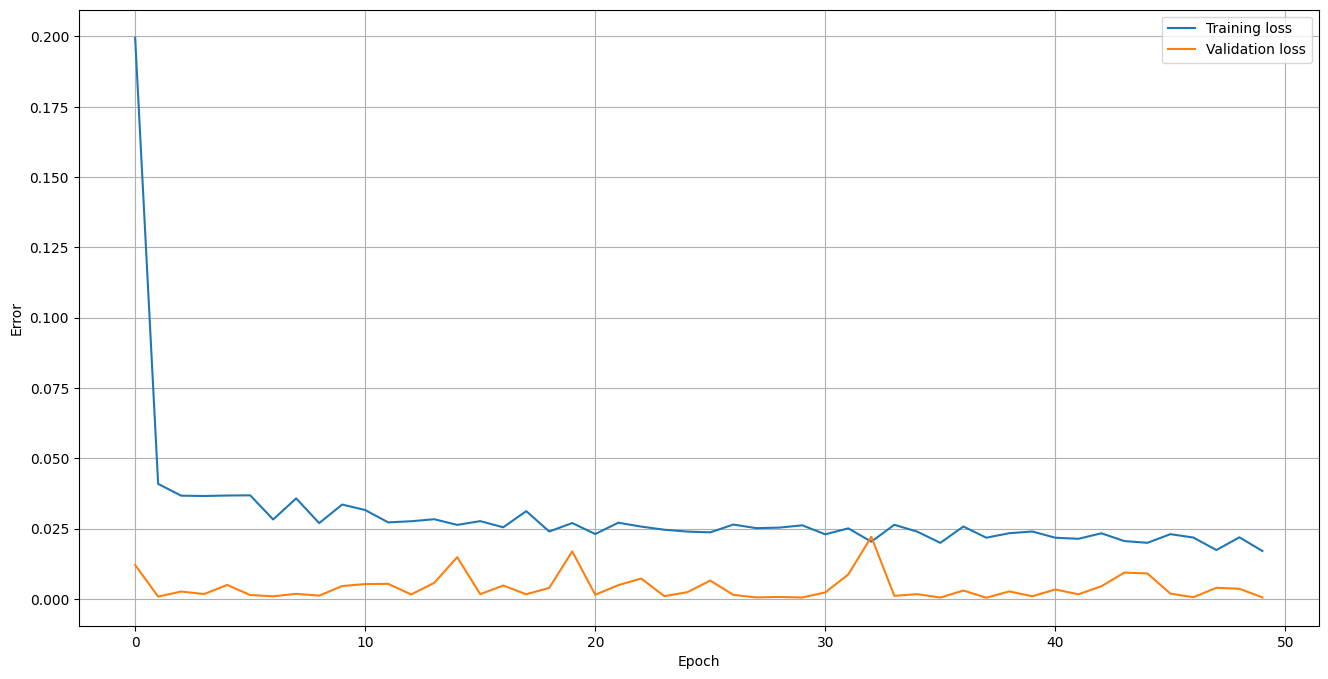

In [394]:
def plot_loss(history):
  plt.figure(figsize=(16,8))
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [395]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rnn_rmse = np.sqrt(np.mean(predictions - y_test)**2)
rnn_rmse

8/8 [==============================] - 0s 3ms/step


2051.5397403029974

In [396]:
# data = nepse_df.filter(['Close'])
# train = data[:training_data_len]
# validation = data[training_data_len:]
# validation['Predictions'] = predictions
# plt.figure(figsize=(16,8))
# plt.title('Training on RNN Model')
# plt.xlabel('Date')
# plt.ylabel('Closing Price')
# plt.plot(train)
# plt.plot(validation[['Close', 'Predictions']])
# plt.legend(['Training', 'Validations', 'Predictions'], loc='upper right')
# plt.show()

### 2. LSTM Model

In [397]:
# Define the RNN Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape= (x_train.shape[1], 3)))
model.add(Dropout(0.2))
model.add(LSTM(units=75, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=20))
model.add(Dense(units=1))
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 5, 50)             10800     
                                                                 
 dropout_87 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_34 (LSTM)              (None, 5, 75)             37800     
                                                                 
 dropout_88 (Dropout)        (None, 5, 75)             0         
                                                                 
 lstm_35 (LSTM)              (None, 50)                25200     
                                                                 
 dropout_89 (Dropout)        (None, 50)                0         
                                                                 
 dense_89 (Dense)            (None, 20)              

In [398]:
epochs = 50
history = model.fit(x_train, y_train, epochs = epochs, validation_split=0.2)

Epoch 1/50
26/26 [==============================] - 15s 155ms/step - loss: 0.2265 - val_loss: 0.0358
Epoch 2/50
26/26 [==============================] - 1s 19ms/step - loss: 0.0588 - val_loss: 0.0240
Epoch 3/50
26/26 [==============================] - 1s 21ms/step - loss: 0.0583 - val_loss: 0.0173
Epoch 4/50
26/26 [==============================] - 1s 22ms/step - loss: 0.0584 - val_loss: 0.0098
Epoch 5/50
26/26 [==============================] - 1s 21ms/step - loss: 0.0491 - val_loss: 0.0117
Epoch 6/50
26/26 [==============================] - 1s 20ms/step - loss: 0.0569 - val_loss: 0.0228
Epoch 7/50
26/26 [==============================] - 1s 21ms/step - loss: 0.0627 - val_loss: 0.0042
Epoch 8/50
26/26 [==============================] - 1s 21ms/step - loss: 0.0428 - val_loss: 0.0067
Epoch 9/50
26/26 [==============================] - 1s 21ms/step - loss: 0.0427 - val_loss: 0.0257
Epoch 10/50
26/26 [==============================] - 1s 24ms/step - loss: 0.0459 - val_loss: 0.0042
Epoch 1

In [399]:
model.save_weights(f"models/{SCRIP}_LSTM.h5")

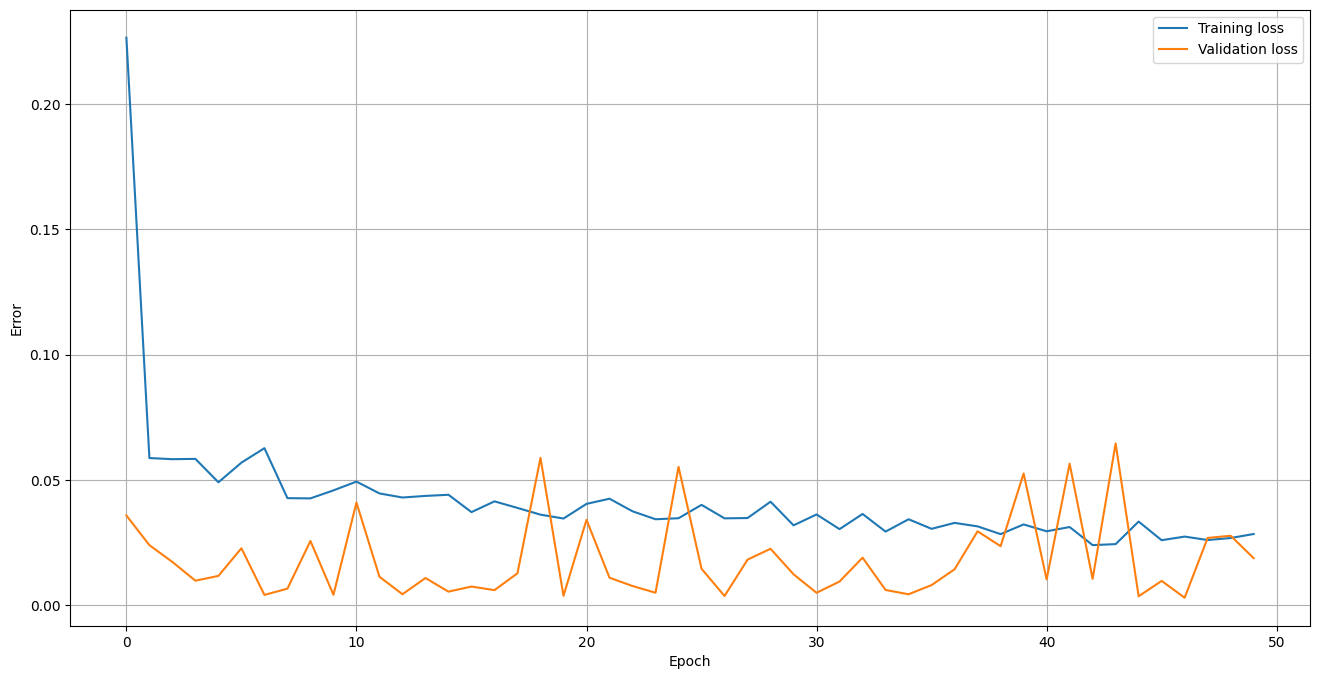

In [400]:
plot_loss(history)

In [401]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
lstm_rmse = np.sqrt(np.mean(predictions - y_test)**2)
lstm_rmse

8/8 [==============================] - 3s 6ms/step


2227.3198936470326

In [402]:
# data = nepse_df.filter(['Close'])
# train = data[:training_data_len]
# validation = data[training_data_len:]
# validation['Predictions'] = predictions
# plt.figure(figsize=(16,8))
# plt.title('Model')
# plt.xlabel('Date')
# plt.ylabel('Closing Price')
# plt.plot(train)
# plt.plot(validation[['Close', 'Predictions']])
# plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
# plt.show()

In [403]:
# if rnn_rmse > lstm_rmse:
#   print("RNN works better than LSTM for", SCRIP)
# elif rnn_rmse < lstm_rmse:
#   print("LSTM works better than RMSE for", SCRIP)
# else:
#   print("The performance of RNN and LSTM are same.")

## Implementing feature engineering and GRU

In [404]:
# Define the GRU Model
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 3)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=75, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=20))
gru_model.add(Dense(units=1))
gru_model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')

# Train the model
gru_history = gru_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
26/26 [==============================] - 10s 84ms/step - loss: 0.1590 - val_loss: 0.0185
Epoch 2/50
26/26 [==============================] - 0s 18ms/step - loss: 0.0422 - val_loss: 0.0043
Epoch 3/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0459 - val_loss: 0.0029
Epoch 4/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0404 - val_loss: 0.0088
Epoch 5/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0312 - val_loss: 0.0084
Epoch 6/50
26/26 [==============================] - 0s 13ms/step - loss: 0.0335 - val_loss: 0.0085
Epoch 7/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0273 - val_loss: 0.0181
Epoch 8/50
26/26 [==============================] - 0s 15ms/step - loss: 0.0281 - val_loss: 0.0034
Epoch 9/50
26/26 [==============================] - 0s 12ms/step - loss: 0.0271 - val_loss: 0.0038
Epoch 10/50
26/26 [==============================] - 1s 23ms/step - loss: 0.0272 - val_loss: 0.0865
Epoch 11

In [405]:
gru_model.save_weights(f"models/{SCRIP}_GRU.h5")

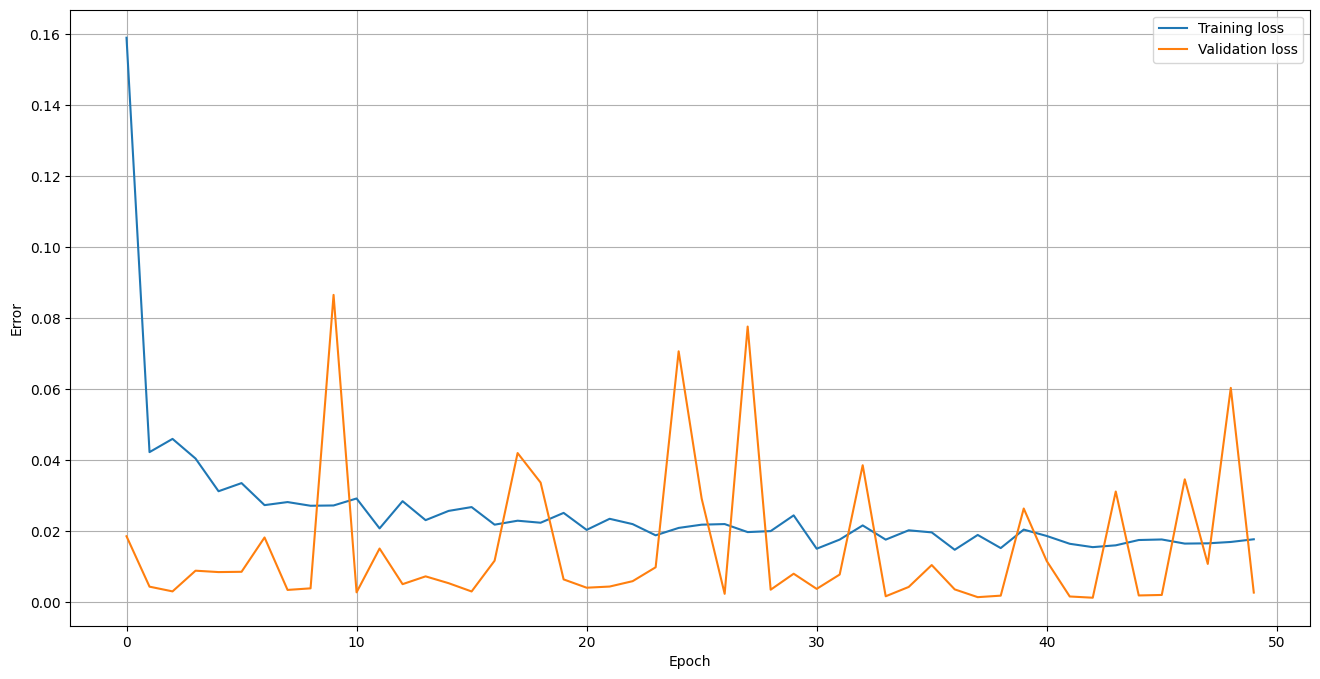

In [406]:
plot_loss(gru_history)